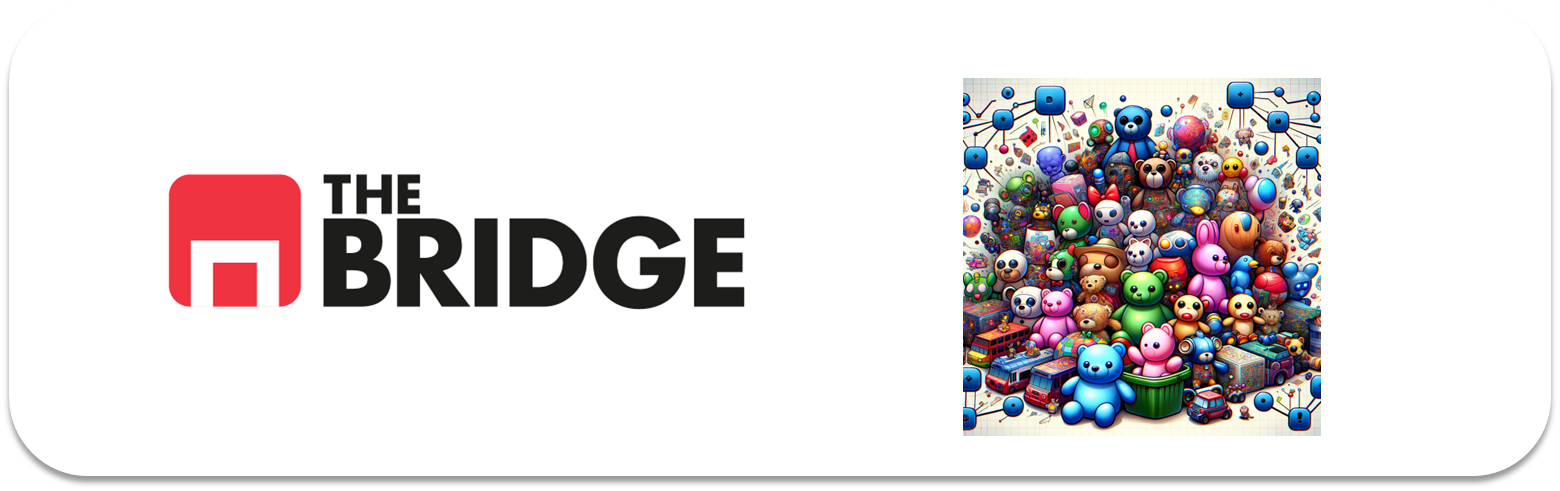

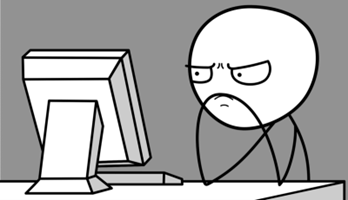

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


Cargamos los datos y los revisamos

In [2]:
df = pd.read_csv("./data/empowering_drinks.csv", sep="|")
df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,0.019231,1.026182,-2.434235,-0.816038,0.061000,0.876275,2.259772
Vitamínas del grupo B,153.0,0.037273,0.995984,-3.679162,-0.499016,-0.023821,0.707247,3.156325
Cafeína,153.0,0.041057,1.040928,-1.695971,-1.043392,0.211566,0.894264,3.062832
Ácido Cítrico,153.0,0.080022,1.009450,-1.493188,-0.738463,-0.165254,0.917474,2.971473
Taurina,153.0,-0.044088,0.934399,-1.634288,-0.799428,-0.154899,0.493956,2.431870


Comentarios:
* No hay valores nulos
* Todas las variables son numéricas continuas
* Tienen escalas similares

Visualizamos todas las variables con un pairplot

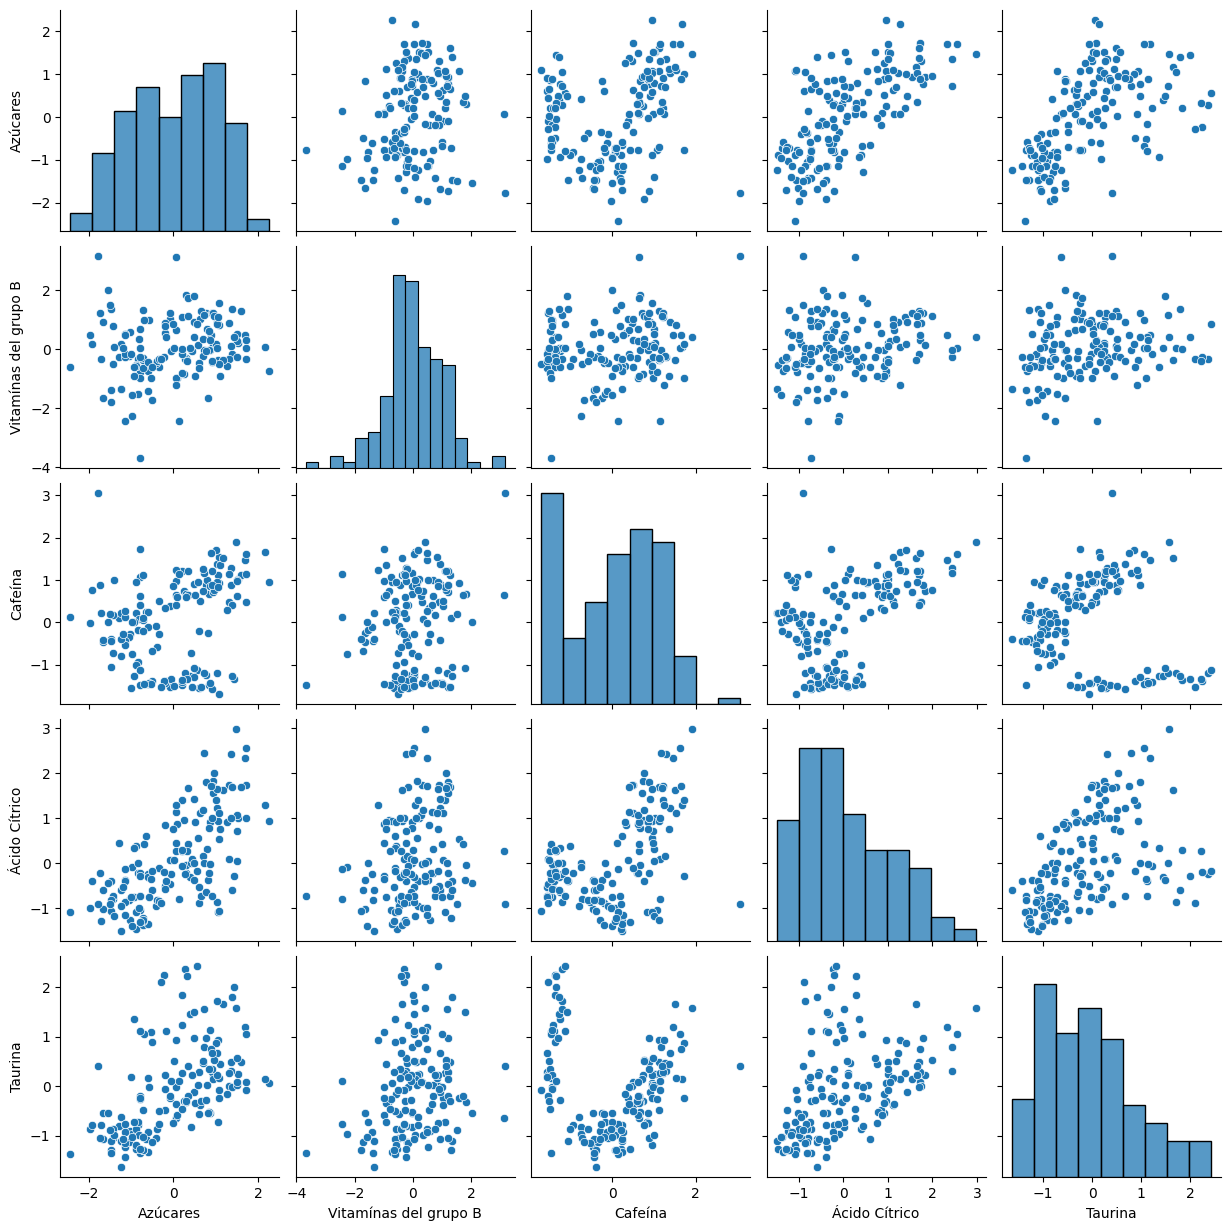

In [5]:
sns.pairplot(df);

Comentarios:
* "Azúcares" con "Cafeína" forman 3 agrupaciones
* Vitaminas del grupo B no se aprecia que forme alguna agrupación evidente con alguna variable
* "Cafeína" y "Taurina" forman 3 agrupaciones
* "Cafeína" y "Ácido Cítrico" forman 3 agrupaciones

Nos vamos a quedar como *features* todas las variables excepto "Vitamínas del grupo B"

In [6]:
features = [columna for columna in df.columns if columna != "Vitamínas del grupo B"]
features

['Azúcares', 'Cafeína', 'Ácido Cítrico', 'Taurina']

Visualizamos la distribución de los valores de las *features*

,count,mean,std,min,25%,50%,75%,max
Azúcares,153.0,0.019231,1.026182,-2.434235,-0.816038,0.061000,0.876275,2.259772
Cafeína,153.0,0.041057,1.040928,-1.695971,-1.043392,0.211566,0.894264,3.062832
Ácido Cítrico,153.0,0.080022,1.009450,-1.493188,-0.738463,-0.165254,0.917474,2.971473
Taurina,153.0,-0.044088,0.934399,-1.634288,-0.799428,-0.154899,0.493956,2.431870


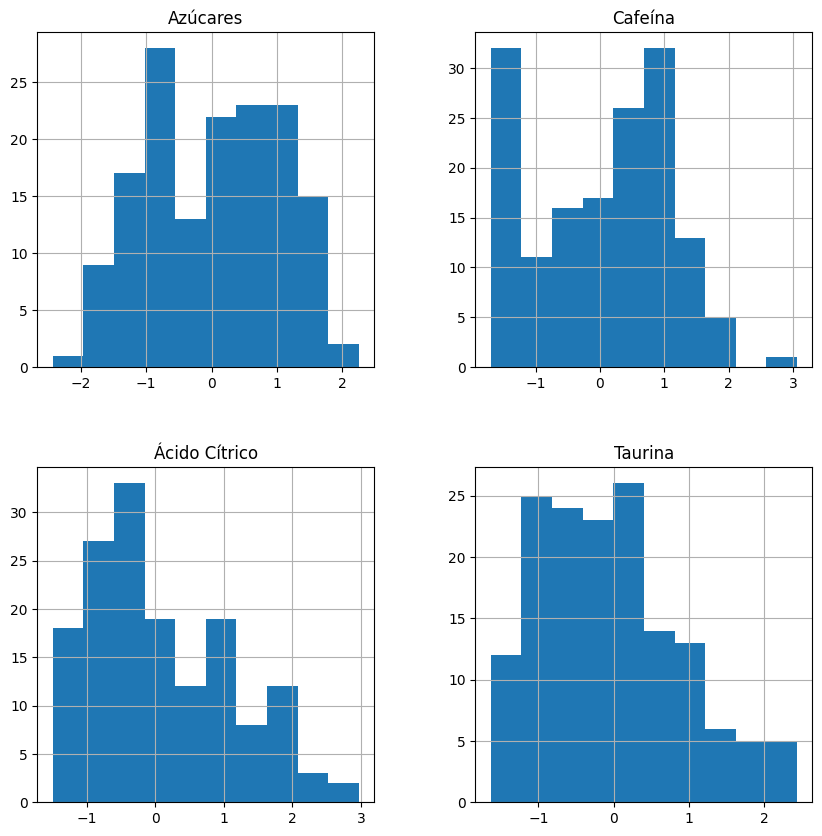

In [7]:
df[features].hist(figsize=(10,10));
df[features].describe().T

Los valores están centrados y tienen escalas similares por lo que no será necesario aplicar ninguna transformación a las *features*

Creamos el DataFrame de entrenamiento

In [8]:
X_train = df[features]
X_train

,Azúcares,Cafeína,Ácido Cítrico,Taurina
0,1.518613,1.034819,1.013009,0.251717
1,0.246290,0.733629,0.965242,-0.293321
2,0.196879,1.215533,1.395148,0.269020
3,1.691550,1.466525,2.334574,1.186068
4,0.295700,0.663351,-0.037874,-0.319276
...,...,...,...,...
148,0.493343,-1.284344,0.009893,0.969783
149,0.332758,-1.344582,0.280575,2.224236
150,0.209232,-1.354622,0.296498,1.834923
151,1.395086,-1.274305,-0.595160,1.791666


Vamos a emplear primero el algoritmo KMeans para obtener una primera clusterización. Aunque tenemos una idea ya por el enunciado y tras analizar el pairplot de que k=3, vamos a confirmarlo con los métodos habituales

**SCORE DE SILUETA**

El máximo silhoutte score se da para k=3


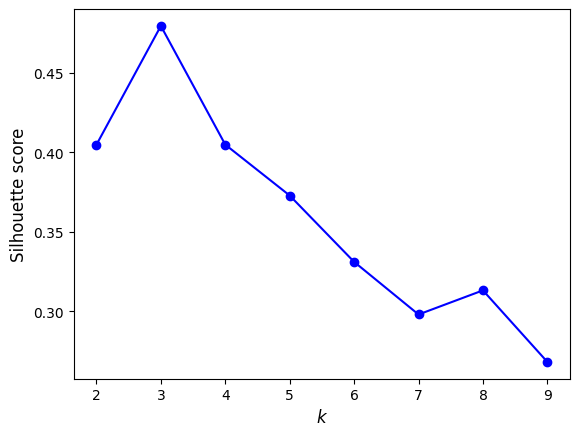

In [9]:
#Calculamos el silhouette score para cada k
ks = []
sil_scores = []

for k in range(2, 10): 
    clustering = KMeans(n_clusters = k, random_state=42)
    clustering.fit(X_train)

    sil_scores.append(silhouette_score(X_train, clustering.labels_))
    ks.append(k)

#Graficamos el silhouette score para cada k
plt.plot(ks, sil_scores, "bo-");
plt.xlabel("$k$", fontsize=12);
plt.ylabel("Silhouette score", fontsize=12);

#Obtenemos el valor de k que maximiza el silhouette score
print(f"El máximo silhoutte score se da para k={ks[sil_scores.index(max(sil_scores))]}")

Con éste método obtenemos que k=3

**CODO DE INERCIA**

,k,inertia,diff
0,1,612.357909,NaN
1,2,349.416379,-262.941529
2,3,194.819948,-154.596432
3,4,159.268949,-35.550999
4,5,136.650586,-22.618363
5,6,120.739924,-15.910662
6,7,110.346775,-10.393148
7,8,101.610136,-8.736639
8,9,92.402735,-9.207402


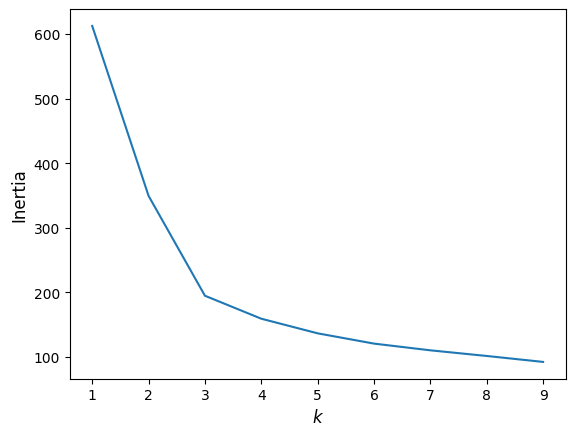

In [10]:
#Probamos con diferentes valores de k
ks = []
inertias = []

for k in range(1, 10):
    
    clustering = KMeans(n_clusters = k, random_state=42)
    clustering.fit(X_train)
    inertias.append(clustering.inertia_)
    ks.append(k)

#Gráfica de las inercias en funcion de k
plt.plot(ks, inertias)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Inertia", fontsize=12);

#Creamos un Dataframe con las inercias
df_inertias = pd.DataFrame({'k': ks, 'inertia': inertias})

#Creamos una columna con la variacion de las inercias
df_inertias['diff'] = df_inertias['inertia'] - df_inertias['inertia'].shift(1)
df_inertias

Aquí tambien se aprecia que el codo se encuentra en k=3. Instanciamos y entrenamos el modelo con k=3

In [11]:
modelo_kmeans = KMeans(n_clusters = 3, random_state=42)
modelo_kmeans.fit(X_train)

KMeans(n_clusters=3, random_state=42)

Creamos un DataFrame con una nueva columna que indique la clusterización

In [12]:
df_cluster_kmeans = df.copy()
df_cluster_kmeans["Cluster"] = modelo_kmeans.predict(X_train)
df_cluster_kmeans

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Cluster
0,1.518613,0.232053,1.034819,1.013009,0.251717,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,1
2,0.196879,1.109334,1.215533,1.395148,0.269020,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,2
...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,0
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,0
150,0.209232,0.012732,-1.354622,0.296498,1.834923,0
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,0


Si lo visualizamos con un pairplot

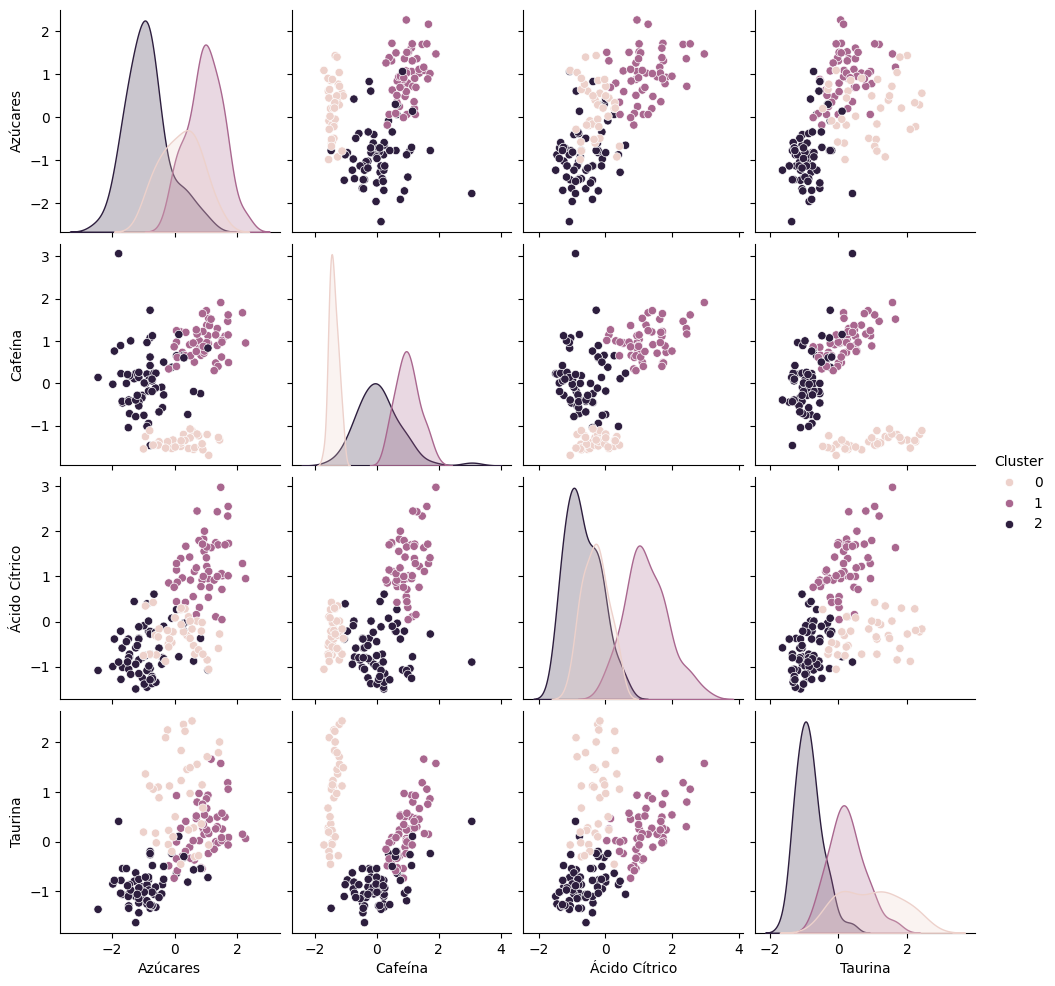

In [13]:
sns.pairplot(df_cluster_kmeans[features+["Cluster"]], hue ="Cluster");

Aunque hay algunas instancias con el cluster mal etiquetado, se observa un buena clusterización según las relaciones entre variables encontradas en el análisis visual realizado previamente

Ahora vamos a usar DBSCAN para comparar. Estimamos el hiperparámetro eps midiendo el porcentaje de "anomalías" que detecta y consideramos como punto de parada un valor por debajo del 15%

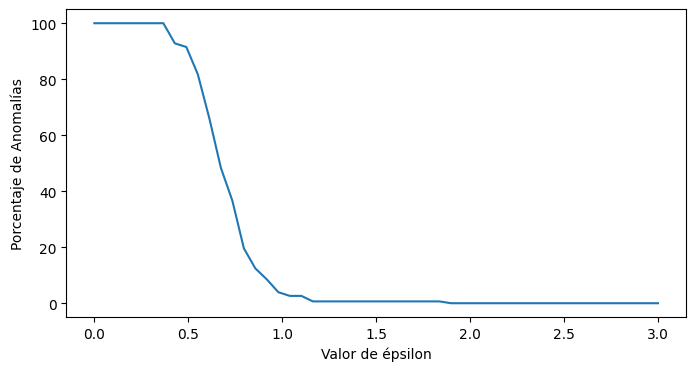

In [14]:
outlier_percent = []

for eps in np.linspace(0.001,3,50): #Genera 50 valores equidistantes entre 0.001 y 3
    
    #Instanciamos el modelo
    dbscan = DBSCAN(eps=eps,min_samples=2*X_train.shape[1]) # min_samples dos veces el numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos
    dbscan.fit(X_train)
     
    #Registramos el porcentaje de anomalías (se etiquetan como -1)
    perc_outliers = (np.sum(dbscan.labels_ == -1) / len(dbscan.labels_))*100
    outlier_percent.append(perc_outliers)

#Mostramos el porcentaje de anomalías en función del valor eps probado
plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)

plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.show()

Vemos el detalle para eps entre 0.7 y 1.0 (a ojo, para ver un rango alrededor del 15% de anomalías)

In [15]:
for indice,eps in [(indice,val) for indice,val in enumerate(np.linspace(0.001,3,50)) if 0.70 <= val <= 1.0]:
    print(f"Para eps={eps.round(2)}: {outlier_percent[indice].round(2)}% de anomalías")

Para eps=0.74: 36.6% de anomalías
Para eps=0.8: 19.61% de anomalías
Para eps=0.86: 12.42% de anomalías
Para eps=0.92: 8.5% de anomalías
Para eps=0.98: 3.92% de anomalías


Nos quedamos con un eps=0.85. Instanciamos el modelo con min_sample dos veces el número de features empleadas

In [16]:
modelo_dbscan = DBSCAN(eps = 0.85, min_samples = 2*len(X_train.columns.to_list()))
modelo_dbscan.fit(X_train)

DBSCAN(eps=0.85, min_samples=8)

Creamos un DataFrame con una nueva columna que indique la clusterización

In [17]:
df_cluster_dbscan = df.copy()
df_cluster_dbscan["Cluster"] = modelo_dbscan.labels_
df_cluster_dbscan

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Cluster
0,1.518613,0.232053,1.034819,1.013009,0.251717,0
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,0
3,1.691550,0.487926,1.466525,2.334574,1.186068,-1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,0
...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,2
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,2
150,0.209232,0.012732,-1.354622,0.296498,1.834923,2
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,-1


Si lo visualizamos con un pairplot

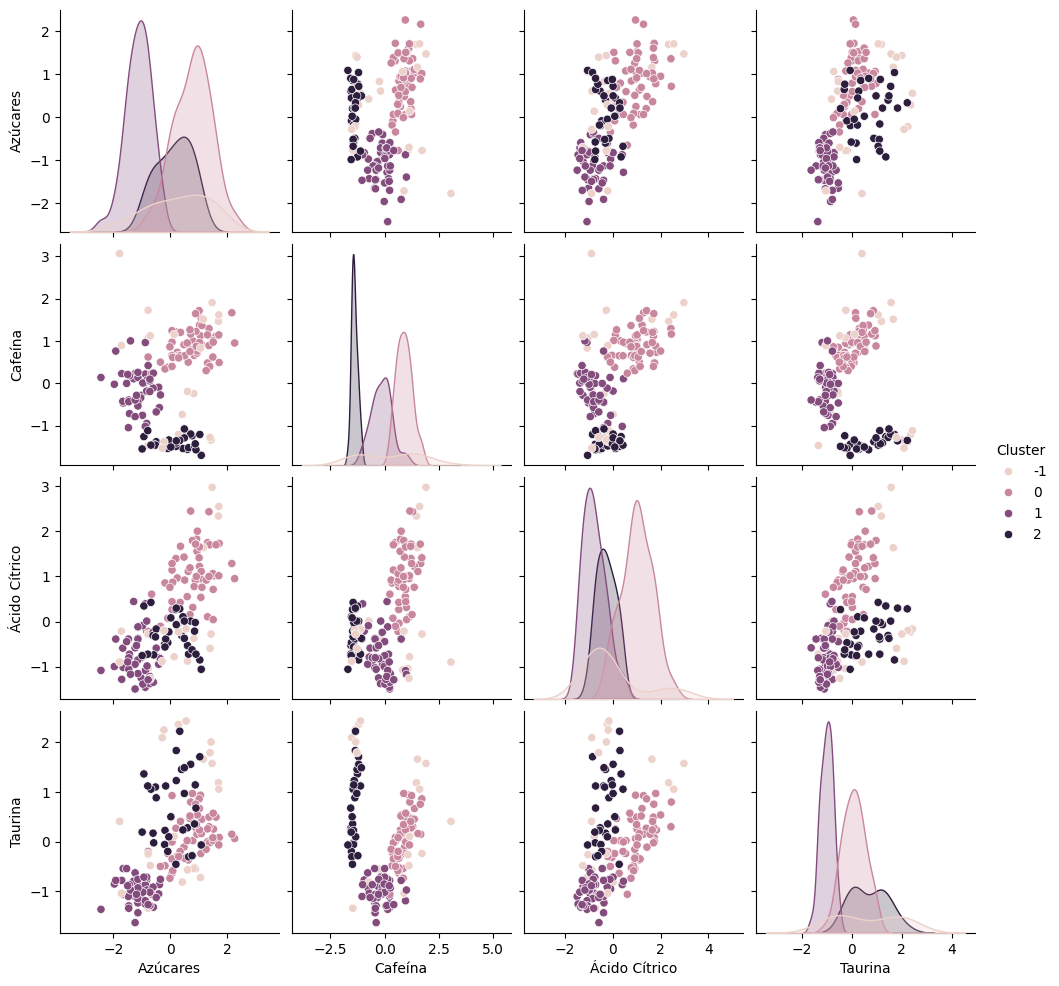

In [18]:
sns.pairplot(df_cluster_dbscan[features+["Cluster"]], hue ="Cluster");

Obtenemos un resultado de 3 clusters también, aunque hay instancias clasificadas como anomalías (por falta de densidad en algunos clusters) que podrían haber sido asignadas a alguno de los clusters como se aprecia en el modelado con KMeans

Por último, vamos a realizar una clusterización jerárquica para obtener la relación entre clusters. Construimos el dendrograma

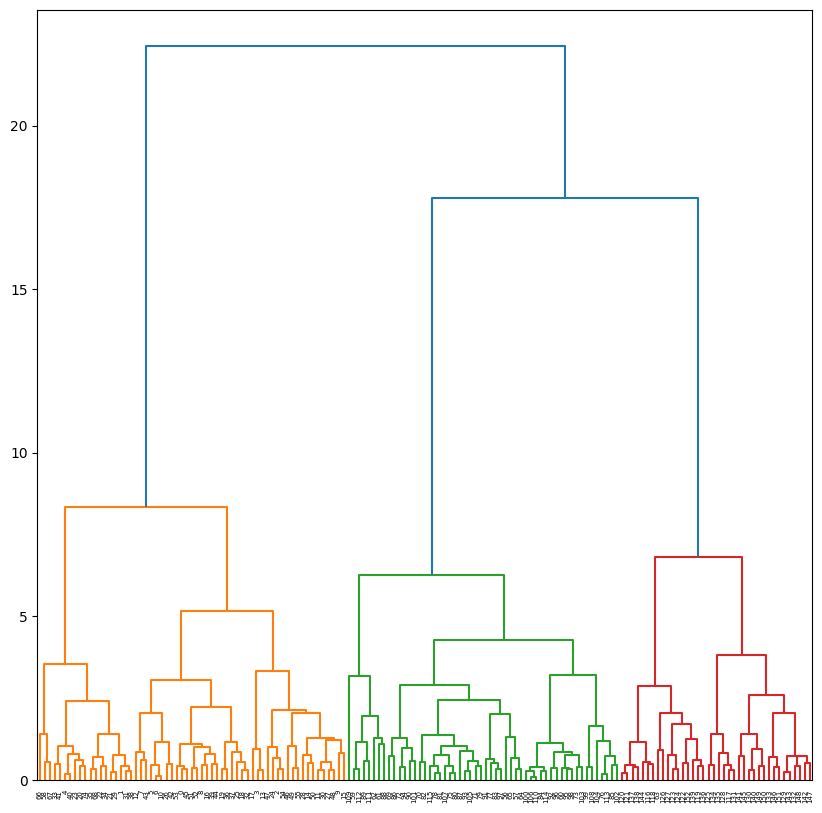

In [19]:
link_method = linkage(X_train, method = 'ward', metric="euclidean")

plt.figure(figsize =(10,10))
dend = dendrogram(link_method)

Aplicando el método del máximo gap colocamos la linea horizontal en torno a 17 y obtenemos 3 clusters

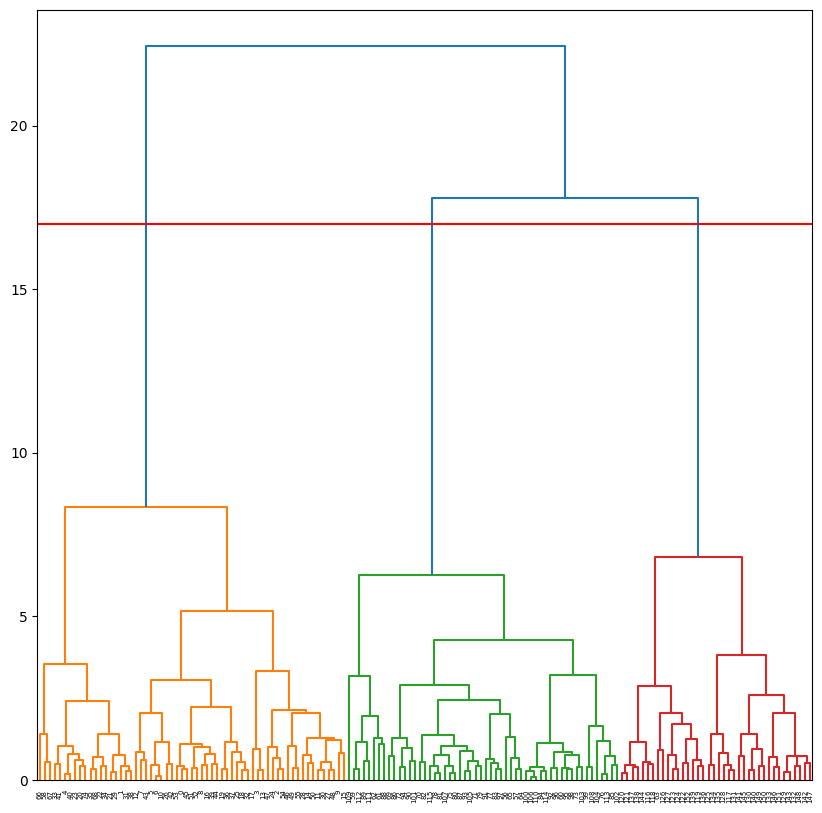

In [23]:
plt.figure(figsize =(10,10))
dend = dendrogram(link_method)
plt.axhline(y = 17, color = 'r', linestyle = '-');

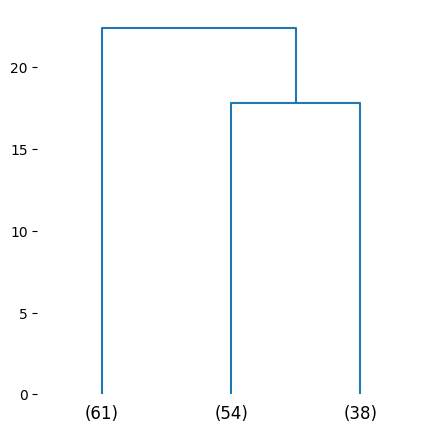

In [20]:
#Miramos cuantos elementos hay en cada cluster
plt.figure(figsize =(5,5))
dend = dendrogram(link_method, truncate_mode='lastp', p = 3)
sns.despine(left=True, bottom=True)

Se observa que hay un primer cluster (61) que tiene 61 instancias, luego hay dos clusters (54) y (38) separados del primero que tienen 54 y 38 instancias, respectivamente, y que a su vez éstos dos están más lejos del primer cluster que entre ellos

Instanciamos un modelo de clusterización aglomerativo con k=3

In [21]:
modelo_aglomerativo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
modelo_aglomerativo.fit(X_train)

AgglomerativeClustering(metric='euclidean', n_clusters=3)

Creamos un DataFrame con una nueva columna que indique la clusterización

In [23]:
df_cluster_aglomerativo = df.copy()
df_cluster_aglomerativo["Cluster"] = modelo_aglomerativo.labels_
df_cluster_aglomerativo

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Cluster
0,1.518613,0.232053,1.034819,1.013009,0.251717,0
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,0
3,1.691550,0.487926,1.466525,2.334574,1.186068,0
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,0
...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,1
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,1
150,0.209232,0.012732,-1.354622,0.296498,1.834923,1
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,1


In [30]:
df_cluster_aglomerativo["Cluster"].value_counts()

Cluster
0    61
2    54
1    38
Name: count, dtype: int64

Observamos las medias de cada *feature* para cada cluster

In [28]:
#Agrupamos por media
features_mean_by_cluster = df_cluster_aglomerativo[features + ["Cluster"]].groupby("Cluster").mean()
features_mean_by_cluster

,Azúcares,Cafeína,Ácido Cítrico,Taurina
Cluster,,,,
0,0.883565,0.919939,1.038746,0.153006
1,0.199364,-1.365581,-0.294533,0.886957
2,-1.083908,0.038103,-0.739406,-0.921910


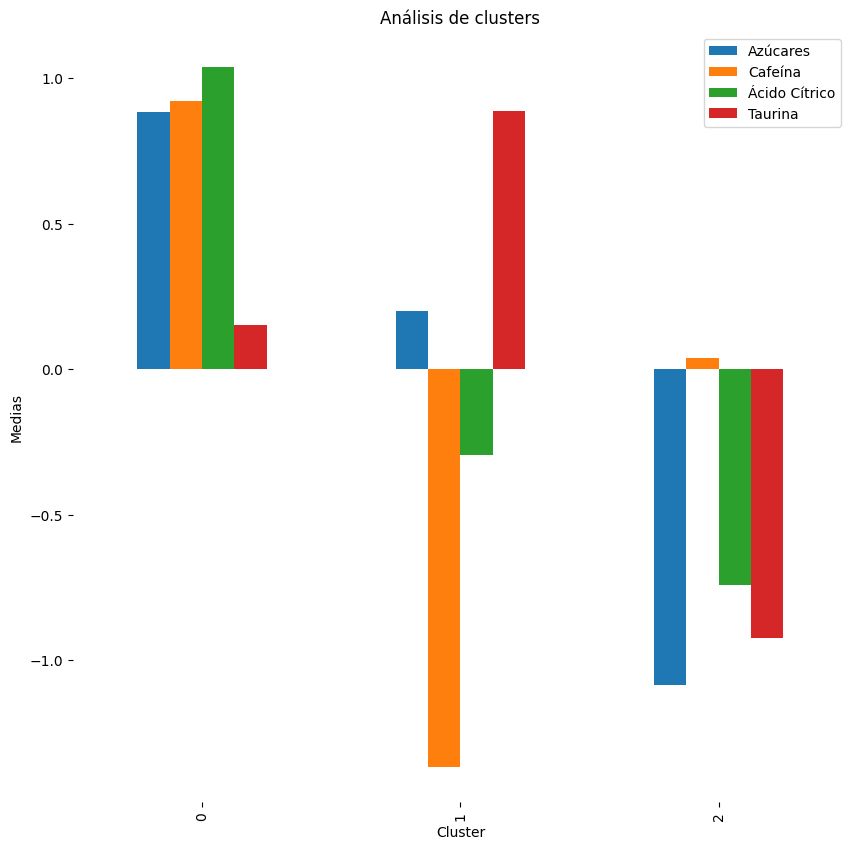

In [29]:
#Mostramos el perfil de cada cluster
fig, ax = plt.subplots(figsize=(10, 10))

features_mean_by_cluster.plot(kind='bar', ax=ax)
ax.set_ylabel('Medias')
ax.set_title('Análisis de clusters')

sns.despine(left=True, bottom=True)
plt.show()

Atendiendo a las distancias entre clusters y a los niveles de componentes:

* El cluster 0 (61 instancias) agrupa bebidas con un contenido bajo de taurina y contenido alto de azúcares, cafeína y ácido cítrico. Se podría considerar en el grupo bebidas de alta energía, con alto nivel de azúcar y de ácido cítrico

* El cluster 1 (38 instancias) agrupa bebidas con un contenido alto de taurina, contenido moderado de azúcar y ácido cítrico y contenido bajo de cafeína. Se podría considerar en el grupo de bebidas de media-alta energía, con un nivel moderado de azúcares y ácido cítrico

* El cluster 2 (54 instancias) agrupa bebidas con un contenido moderado de cafeína y contenido bajo de azúcares, ácido cítrico y taurina. Se podría considerar en el grupo de bebidas de media energía, con un nivel bajo de azúcares y ácido cítrico

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [31]:
new_data = pd.read_csv("./data/new_experiments.csv", sep="|")
new_data

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


Usamos el modelo KMeans creado anteriormente para obtener el cluster de esas 6 nuevas instancias y lo incluimos en el DataFrame

In [32]:
new_data_cluster = new_data.copy()
new_data_cluster["Cluster"] = modelo_kmeans.predict(new_data[features])

new_data_cluster

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Cluster
0,1.481555,0.305159,1.366128,2.239039,0.731870,1
1,0.616869,0.890014,0.583034,0.312420,-0.665332,1
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,2
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,2
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,2
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043,0


Tenemos que dos de las instancias van a un cluster, tres de las instancias van a otro cluster y sólo una instancia va a un tercer cluster

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [33]:
#Creamos el DataFrame con todos los experimentos y los resultados proporcionados
df_experimentos = pd.concat([df, new_data], axis=0, ignore_index=True)

#Leemos el archivo que contiene los resultados
resultados = pd.read_csv("./data/power_results.csv", sep="|")
resultados.rename(columns={"class":"Resultados"}, inplace=True )

#Obtenemos la clusterización dada por el modelo KMeans
cluster_kmeans = modelo_kmeans.fit_predict(df_experimentos[features])

#Obtenemos la clusterización dada por el modelo DBSCAN
modelo_dbscan.fit(df_experimentos[features])
cluster_dbscan = modelo_dbscan.labels_

#Obtenemos la clusterización dada por el modelo de clusterización jerárquica aglomerativa
cluster_aglomerativo = modelo_aglomerativo.fit_predict(df_experimentos[features])

#Unimos los resultados y las predicciones al DataFrame con todos los experimentos
df_resultados = pd.concat([df_experimentos, resultados], axis=1)

df_resultados["Cluster_KMeans"] = cluster_kmeans
df_resultados["Cluster_DBSCAN"] = cluster_dbscan
df_resultados["Cluster_aglomerativo"] = cluster_aglomerativo

df_resultados

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Resultados,Cluster_KMeans,Cluster_DBSCAN,Cluster_aglomerativo
0,1.518613,0.232053,1.034819,1.013009,0.251717,1,2,0,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,1,2,0,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,1,2,0,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,1,2,-1,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,1,2,0,0
...,...,...,...,...,...,...,...,...,...
154,0.616869,0.890014,0.583034,0.312420,-0.665332,1,2,0,0
155,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,2,0,1,0
156,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,2,0,1,0
157,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,3,0,1,0


Observamos la distribución de los resultados para compararlos con los de la clusterización de cada modelo

In [34]:
for columna in [columna for columna in df_resultados.columns if "Cluster" in columna or "Resultados" in columna]:
    print(f"La distribución de valores para {columna} es:\n{df_resultados[columna].value_counts().sort_values(ascending=False)}\n")

La distribución de valores para Resultados es:
Resultados
2    62
1    58
3    39
Name: count, dtype: int64

La distribución de valores para Cluster_KMeans es:
Cluster_KMeans
0    65
2    56
1    38
Name: count, dtype: int64

La distribución de valores para Cluster_DBSCAN es:
Cluster_DBSCAN
 0    58
 1    48
 2    36
-1    17
Name: count, dtype: int64

La distribución de valores para Cluster_aglomerativo es:
Cluster_aglomerativo
0    77
1    43
2    39
Name: count, dtype: int64



Comentarios:
* El modelo DBSCAN es el que peor resultados obtiene porque hay 17 instancias etiquetadas como anomalías y por lo tanto no tienen cluster
* Para el tercer cluster (en cantidad de instancias) tanto KMeans como jerárquico aglomerativo lo hacen bastante bien, pero KMeans discrimina mejor las instancias a asignar en los otros dos clusters